In [1]:
#| output: false
import src
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

td = pd.read_pickle('../results/dekodec/Prez_20220721_dekodec_split.pkl')
td.columns

Index(['M1_spikes', 'M1_unit_guide', 'MC_spikes', 'MC_unit_guide',
       'PMd_spikes', 'PMd_unit_guide', 'bin_size', 'cst_cursor_command',
       'ct_location', 'cursor_pos', 'date_time', 'hand_pos', 'idx_cstEndTime',
       'idx_cstStartTime', 'idx_ctHoldTime', 'idx_endTime', 'idx_failTime',
       'idx_goCueTime', 'idx_pretaskHoldTime', 'idx_rewardTime',
       'idx_rtHoldTimes', 'idx_rtgoCueTimes', 'idx_startTime', 'lambda',
       'monkey', 'raw_left_eye_pos', 'raw_left_pupil', 'rel_cursor_pos',
       'rel_hand_pos', 'result', 'rt_locations', 'task', 'trial_id',
       'session_date', 'M1_rates', 'MC_rates', 'PMd_rates', 'lfads_rates',
       'lfads_inputs', 'hand_vel', 'hand_acc', 'cursor_vel', 'hand_speed',
       'Time from go cue (s)', 'Time from task cue (s)', 'trialtime',
       'lfads_rates_joint_pca', 'lfads_rates_joint_pca_cst_unique',
       'lfads_rates_joint_pca_rtt_unique', 'lfads_rates_joint_pca_shared',
       'lfads_rates_joint_pca_split'],
      dtype='object')

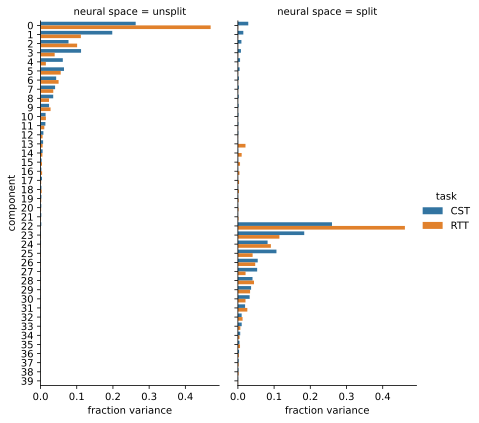

In [2]:
src.plot.plot_split_subspace_variance(td,signal='lfads_rates_joint_pca')

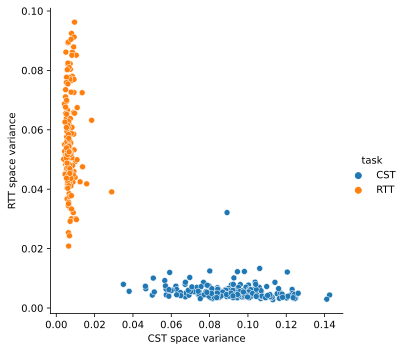

In [3]:
src.plot.plot_single_trial_split_var(td,signal='lfads_rates_joint_pca')

In [4]:
signal = 'lfads_rates_joint_pca_shared'
df = src.decoder_analysis.precondition_td(td, signal)
models = src.decoder_analysis.fit_models(df, signal, target_name='Hand velocity')

trial_scores = src.decoder_analysis.score_trials(df.loc[df['Test set']],signal,models,target_name='Hand velocity')

fig = px.scatter(
    trial_scores.reset_index(),
    x='CST score',
    y='RTT score',
    color='task',
    hover_data=['trial_id'],
    marginal_x='violin',
    marginal_y='violin',
    template='plotly_white',
    width=600,
    height=600,
    color_discrete_sequence=px.colors.qualitative.T10,
)
fig.show()

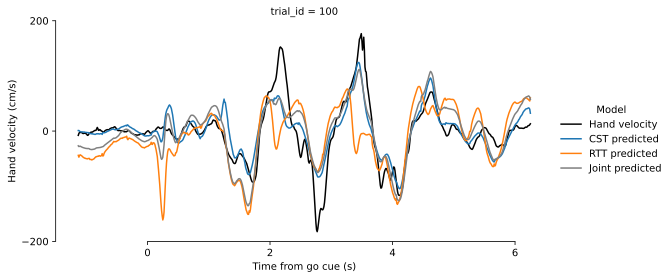

In [36]:
trials_to_plot = [100]
trial_pred = (
    df
    .set_index(['trial_id'])
    .loc[trials_to_plot]
    .pipe(src.decoder_analysis.model_predict, signal, models)
    .reset_index()
    .melt(
        id_vars=['trial_id','Time from go cue (s)','task'],
        value_vars=['Hand velocity','CST predicted','RTT predicted','Joint predicted'],
        var_name='Model',
        value_name='Hand velocity (cm/s)',
    )
)
g=sns.relplot(
    data=trial_pred,
    x='Time from go cue (s)',
    y='Hand velocity (cm/s)',
    hue='Model',
    hue_order=['Hand velocity','CST predicted','RTT predicted','Joint predicted'],
    palette=['k','C0','C1','0.5'],
    kind='line',
    row='trial_id',
    row_order=trials_to_plot,
    height=4,
    aspect=2,
)
g.axes[0,0].set_yticks([-200,0,200])
g.axes[0,0].set_xticks([0,2,4,6])
sns.despine(fig=g.fig,trim=True)

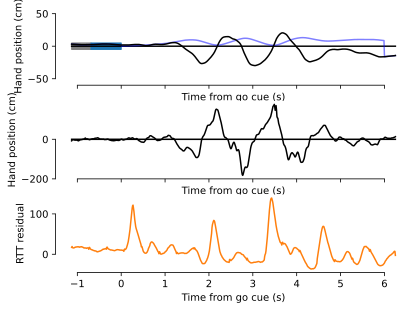

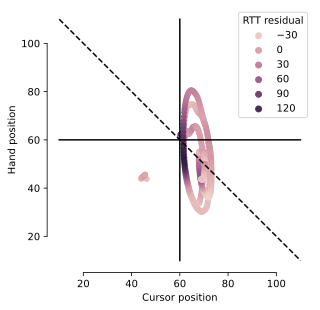

In [35]:
trials_to_plot = [100]
df_resid = (
    df
    .pipe(src.decoder_analysis.model_predict, signal, models)
    .assign(
        **{
            f'{model} residual': lambda d,model=model: d['Joint predicted']-d[f'{model} predicted']
            for model in ['CST','RTT']
        }
    )
)
trial_resid = (
    df_resid
    .set_index(['trial_id'])
    .loc[trials_to_plot]
    .reset_index()
)

trial = td.loc[td['trial_id']==trials_to_plot[0],:].squeeze()
fig,axs = plt.subplots(3,1,sharex=True)
src.plot.plot_hand_trace(trial,ax=axs[0],timesig='Time from go cue (s)')
src.plot.plot_hand_velocity(trial,ax=axs[1],timesig='Time from go cue (s)')
sns.lineplot(
    data=trial_resid,
    x='Time from go cue (s)',
    y='RTT residual',
    ax=axs[2],
    color='C1',
)
sns.despine(fig=fig,trim=True)

sm_fig,sm_ax = plt.subplots(1,1)
sns.scatterplot(
    data=trial_resid,
    x='Cursor position',
    y='Hand position',
    hue='RTT residual',
    ax=sm_ax,
    #palette='viridis',
    linewidth=0,
)
sm_ax.plot([60,60],[10,110],'k-')
sm_ax.plot([10,110],[60,60],'k-')
sm_ax.plot([10,110],[110,10],'k--')
sm_ax.set_aspect('equal')
sns.despine(ax=sm_ax,trim=True)

The "joint predicted" and "RTT predicted" decoder predictions are basically scaled and shifted projections of the neural activity along different axes. The two predictions are normally matched with intermittent mismatches, which means that the subspace spanned by the two axes has activity that is one-dimensional most of the time, but sometimes breaks out of the 1D subspace, but only during CST. It would be good here to know what the angles are between the different decoder axes, so let's find out.

In [7]:
joint_axis = models['Joint'].coef_ / np.linalg.norm(models['Joint'].coef_)
rtt_axis = models['RTT'].coef_ / np.linalg.norm(models['RTT'].coef_)
cst_axis = models['CST'].coef_ / np.linalg.norm(models['CST'].coef_)

print(f'angle between joint and rtt axes: {180/np.pi * np.arccos(np.dot(joint_axis,rtt_axis))}')
print(f'angle between joint and cst axes: {180/np.pi * np.arccos(np.dot(joint_axis,cst_axis))}')
print(f'angle between rtt and cst axes: {180/np.pi * np.arccos(np.dot(rtt_axis,cst_axis))}')

angle between joint and rtt axes: 32.19368875123829
angle between joint and cst axes: 37.163028521247114
angle between rtt and cst axes: 66.3896997064471


Following the idea of the subspace spanned by decoder axes, it would be good to know what the angle between different decoder axes is. Let's investigate.

Here, we have a problem: if you have two axes in high-d space, how do you visualize a low-d version of it? That is, how do you find an orthonormal projection of the high-d space that has the same column space as the span of the two axes, and then also plot the two axes into that space as well?

At first, I thought maybe SVD would be the answer, with the $U$ matrix being the orthonormal projection matrix and $SV^H$ being the two axes in that space. But if $SV^H$ is the two axes, then the two axes in that space are necessarily orthogonal, which doesn't make sense--we know that the axes are not orthogonal.

...actually, I take that back--$SV^H$ is not necessarily orthogonal. $V$ is, but when multiplied by $S$, it's not necessarily orthogonal. Still, it may be simpler to use a different method: QR decomposition. QR decomposition will decompose the matrix of two axes into a matrix $Q$ that is orthonormal (a projection matrix to take the neural activity into the input space of the velocity decoders) and a matrix $R$ that is upper triangular (the two axes in the input space of the velocity decoders). One nice aspect of the QR decomposition is that projecting the neural activity through $Q$ will use only the first dimension as the input to the first velocity decoder axis, which makes the decoder axis plots a bit more natural.

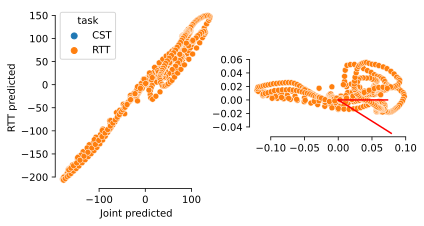

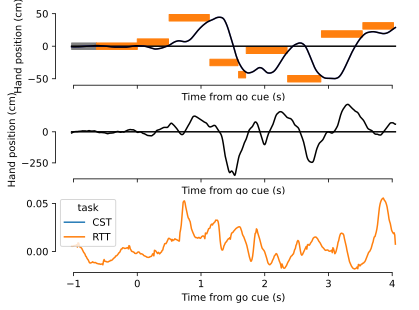

In [44]:
# trials_to_plot = [196,263,322]
trials_to_plot = [380]
trial_pred = (
    df
    .pipe(src.decoder_analysis.model_predict, signal, models)
    .set_index(['trial_id','task','Test set','Time from go cue (s)'])
    .loc[trials_to_plot]
    .reset_index()
)

# Plot out orthonormalized joint and RTT axis projections
axis_to_compare = 'RTT'
Q, R = np.linalg.qr(
    np.column_stack([models['Joint'].coef_,models[axis_to_compare].coef_,models['CST'].coef_]),
)
vel_vectors = -R * 5e-5
# vel_vectors = vh * 0.1

fig,ax = plt.subplots(1,2)
sns.scatterplot(
    data=trial_pred,
    x='Joint predicted',
    y=f'{axis_to_compare} predicted',
    hue='task',
    palette=['C0','C1'],
    hue_order=['CST','RTT'],
    ax=ax[0]
)
ax[0].set_aspect('equal')
sns.scatterplot(
    x= np.row_stack(trial_pred['lfads_rates_joint_pca_shared']) @ -Q[:,0],
    y= np.row_stack(trial_pred['lfads_rates_joint_pca_shared']) @ -Q[:,1],
    hue = trial_pred['task'],
    palette=['C0','C1'],
    hue_order=['CST','RTT'],
    ax=ax[1],
    legend=False,
)
ax[1].plot([0,vel_vectors[0,0]],[0,vel_vectors[1,0]],'r-')
ax[1].plot([0,vel_vectors[0,1]],[0,vel_vectors[1,1]],'r-')
ax[1].set_aspect('equal')
sns.despine(fig=fig,trim=True)

fig_3d = px.scatter_3d(
    x= np.row_stack(trial_pred['lfads_rates_joint_pca_shared']) @ -Q[:,0],
    y= np.row_stack(trial_pred['lfads_rates_joint_pca_shared']) @ -Q[:,1],
    z= np.row_stack(trial_pred['lfads_rates_joint_pca_shared']) @ -Q[:,2],
    color= trial_pred['Hand velocity'],
)
fig_3d.show()

trial = td.loc[td['trial_id']==trials_to_plot[0],:].squeeze()
fig,axs = plt.subplots(3,1,sharex=True)
src.plot.plot_hand_trace(trial,ax=axs[0],timesig='Time from go cue (s)')
src.plot.plot_hand_velocity(trial,ax=axs[1],timesig='Time from go cue (s)')
sns.lineplot(
    x=trial_pred['Time from go cue (s)'],
    y=np.row_stack(trial_pred['lfads_rates_joint_pca_shared']) @ -Q[:,1],
    hue=trial_pred['task'],
    palette=['C0','C1'],
    hue_order=['CST','RTT'], 
    ax=axs[2],
)
sns.despine(fig=fig,trim=True)

In [158]:
temp = (
    df
    .set_index(['trial_id','task','Test set','Time from go cue (s)'])
    .pipe(src.crystal.express_crystallize,single_cols=['Hand position','Hand velocity','Cursor position','Cursor velocity'],array_cols=['lfads_rates_joint_pca_shared'])
)
temp

signal                                      Hand position Hand velocity  \
channel                                                0             0    
trial_id task Test set Time from go cue (s)                               
1        CST  True     -0.88                    55.975703      5.973144   
                       -0.87                    56.035850      6.727050   
                       -0.86                    56.110244      8.104012   
                       -0.85                    56.197930      9.122670   
                       -0.84                    56.292698      9.736655   
...                                                   ...           ...   
394      CST  True      2.05                    87.525364     -5.893637   
                        2.06                    87.472279     -5.828899   
                        2.07                    87.408786     -7.843264   
                        2.08                    87.315414    -10.834871   
                        2.09                    87.192088    -12.983107   

signal                                      Cursor position Cursor velocity  \
channel                                                  0               0    
trial_id task Test set Time from go cue (s)                                   
1        CST  True     -0.88                      55.974293        5.729341   
                       -0.87                      56.033840        7.036972   
                       -0.86                      56.115033        7.958073   
                       -0.85                      56.193002        9.014685   
                       -0.84                      56.295327        9.986239   
...                                                     ...             ...   
394      CST  True      2.05                      87.525579       -5.938797   
                        2.06                      87.471843       -5.823107   
                        2.07                      87.409117       -7.822422   
                        2.08                      87.315395      -10.855589   
                        2.09                      87.192005      -12.996360   

signal                                      lfads_rates_joint_pca_shared  \
channel                                                               0    
trial_id task Test set Time from go cue (s)                                
1        CST  True     -0.88                                    0.026831   
                       -0.87                                    0.027341   
                       -0.86                                    0.022669   
                       -0.85                                    0.017992   
                       -0.84                                    0.016639   
...                                                                  ...   
394      CST  True      2.05                                    0.007614   
                        2.06                                    0.005667   
                        2.07                                    0.003235   
                        2.08                                   -0.007763   
                        2.09                                   -0.046637   

signal                                                                     \
channel                                            1         2         3    
trial_id task Test set Time from go cue (s)                                 
1        CST  True     -0.88                 0.302527 -0.043103 -0.223862   
                       -0.87                 0.304128 -0.041529 -0.225431   
                       -0.86                 0.298993 -0.040560 -0.224790   
                       -0.85                 0.291360 -0.038510 -0.223006   
                       -0.84                 0.285469 -0.033605 -0.220723   
...                                               ...       ...       ...   
394      CST  True      2.05                -0.001715 -0.039409  0.104983   
       